In [37]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from xgboost import XGBRegressor

In [38]:
df = pd.read_excel(r"C:\Users\alexa\OneDrive\Área de Trabalho\repositorios_git\DNC_repository\series_temporais\base_arima_energy.xlsx", index_col="DATE", parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [39]:
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


In [40]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (24, 1))

In [41]:
df.columns = ['producao']

In [42]:
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [43]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

<AxesSubplot:xlabel='DATE'>

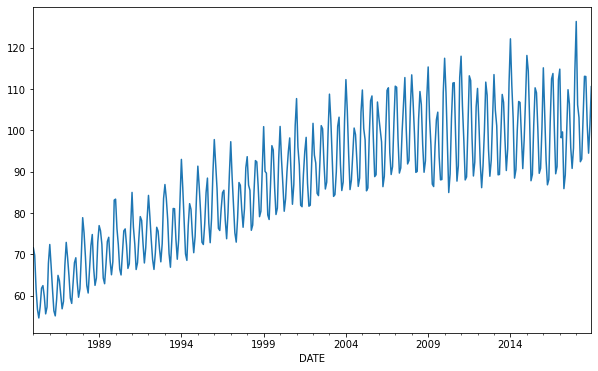

In [44]:
df['producao'].plot(figsize=(10,6))

<Figure size 576x360 with 0 Axes>

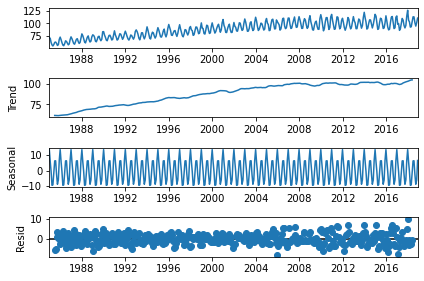

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8,5))
fig = resultado.plot()

In [46]:
treino.columns = ['producao']

In [47]:
treino['producao']

DATE
1985-01-01     71.5920
1985-02-01     69.7870
1985-03-01     61.6790
1985-04-01     56.7479
1985-05-01     54.6165
                ...   
2016-08-01    113.7734
2016-09-01    100.7221
2016-10-01     89.5068
2016-11-01     91.2292
2016-12-01    112.3141
Name: producao, Length: 384, dtype: float64

In [48]:
treino['producao'].shift(-1)

DATE
1985-01-01     69.7870
1985-02-01     61.6790
1985-03-01     56.7479
1985-04-01     54.6165
1985-05-01     57.3509
                ...   
2016-08-01    100.7221
2016-09-01     89.5068
2016-10-01     91.2292
2016-11-01    112.3141
2016-12-01         NaN
Name: producao, Length: 384, dtype: float64

In [49]:
treino['target'] = treino['producao'].shift(-1)
treino.head()

C:\Users\alexa\AppData\Local\Temp\ipykernel_9292\2603432735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino['producao'].shift(-1)


,producao,target
DATE,,
1985-01-01,71.5920,69.7870
1985-02-01,69.7870,61.6790
1985-03-01,61.6790,56.7479
1985-04-01,56.7479,54.6165
1985-05-01,54.6165,57.3509


In [50]:
treino.tail()

,producao,target
DATE,,
2016-08-01,113.7734,100.7221
2016-09-01,100.7221,89.5068
2016-10-01,89.5068,91.2292
2016-11-01,91.2292,112.3141
2016-12-01,112.3141,NaN


In [51]:
treino = treino.dropna()
treino.tail()

,producao,target
DATE,,
2016-07-01,112.4736,113.7734
2016-08-01,113.7734,100.7221
2016-09-01,100.7221,89.5068
2016-10-01,89.5068,91.2292
2016-11-01,91.2292,112.3141


In [52]:
validacao.columns = ['producao']

In [53]:
validacao['target'] = validacao['producao'].shift(-1)
validacao.head()

C:\Users\alexa\AppData\Local\Temp\ipykernel_9292\3527523697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacao['target'] = validacao['producao'].shift(-1)


,producao,target
DATE,,
2017-01-01,114.8282,98.2191
2017-02-01,98.2191,99.6408
2017-03-01,99.6408,85.9106
2017-04-01,85.9106,89.2053
2017-05-01,89.2053,99.1945


In [54]:
validacao.tail()

,producao,target
DATE,,
2018-08-01,113.0449,101.4058
2018-09-01,101.4058,94.4922
2018-10-01,94.4922,101.3895
2018-11-01,101.3895,110.5936
2018-12-01,110.5936,NaN


In [55]:
validacao = validacao.dropna()
validacao.tail()

,producao,target
DATE,,
2018-07-01,113.0893,113.0449
2018-08-01,113.0449,101.4058
2018-09-01,101.4058,94.4922
2018-10-01,94.4922,101.3895
2018-11-01,101.3895,110.5936


In [56]:
X_treino = treino.loc[:, ['producao']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['producao']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (23, 1), (23, 1))

In [57]:
modelo_xgba = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgba.fit(X_treino, y_treino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
validacao.iloc[0]

producao    114.8282
target       98.2191
Name: 2017-01-01 00:00:00, dtype: float64

In [59]:
predicao = modelo_xgba.predict(X_validacao)
predicao

array([102.46811 ,  89.281204, 109.23927 ,  76.31653 ,  92.35075 ,
       100.79523 , 101.110825, 112.78427 , 111.64093 ,  97.63219 ,
       111.64093 , 102.46811 , 110.42596 ,  97.12213 , 103.98904 ,
        97.24701 ,  86.27949 , 106.806046, 115.00682 , 115.00682 ,
       113.205345, 100.565254, 113.205345], dtype=float32)

In [60]:
validacao["pred"] = predicao
validacao.head()

,producao,target,pred
DATE,,,
2017-01-01,114.8282,98.2191,102.468109
2017-02-01,98.2191,99.6408,89.281204
2017-03-01,99.6408,85.9106,109.239273
2017-04-01,85.9106,89.2053,76.316528
2017-05-01,89.2053,99.1945,92.350754


In [61]:
from sklearn import metrics

In [62]:
print('MAE:', metrics.mean_absolute_error(X_validacao, predicao))
print('MSE:', metrics.mean_squared_error(X_validacao, predicao))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_validacao, predicao)))

MAE: 8.064895589546536
MSE: 86.1607819876361
RMSE: 9.28228323138419
